<a href="https://colab.research.google.com/github/paolo2004/LSTM_Projekt/blob/master/stock_price_prediction_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict stock prices  with Long short-term memory (LSTM)

This simple example will show you how LSTM models predict time series data. Stock market data is a great choice for this because it's quite regular and widely available via the Internet.

## Install requirements
We install Tensorflow 2.0 with GPU support first

In [1]:
!pip install tensorflow-gpu==2.0.0-alpha0

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.0.0-alpha0 (from versions: 2.12.0)

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for tensorflow-gpu==2.0.0-alpha0


In [2]:
!pip install pandas-datareader


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!apt install graphviz

Der Befehl "apt" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


In [4]:
!pip install pydot pydot-ng


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## Introduction

LSTMs are very powerful in sequence prediction problems. They can store past information.

## Loading the dataset
I use pandas-datareader to get the historical stock prices from Yahoo! finance. For this example, I get only the historical data till the end of *training_end_data*.  

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data

In [13]:
import yfinance as yf
tickers = 'AAPL'

start_date = '2024-01-01'
end_date = '2024-12-31'

stock_data = yf.download(tickers, start_date, end_date, interval='60m')

C:\Users\nangu\AppData\Local\Temp\ipykernel_24112\2205500800.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(tickers, start_date, end_date, interval='60m')
[*********************100%***********************]  1 of 1 completed


In [14]:
stock_data.head(10)

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Datetime,,,,,
2024-01-02 14:30:00+00:00,186.189896,188.440002,186.009995,187.800995,21173291
2024-01-02 15:30:00+00:00,186.804993,186.904999,185.184296,186.179993,9010595
2024-01-02 16:30:00+00:00,186.615005,187.350006,186.570007,186.800003,6143754
2024-01-02 17:30:00+00:00,185.294998,187.039993,185.259995,186.615005,5381701
2024-01-02 18:30:00+00:00,184.494995,185.539993,184.229996,185.289993,7228643
2024-01-02 19:30:00+00:00,184.419998,184.679993,183.884995,184.490005,8238940
2024-01-02 20:30:00+00:00,185.524994,185.639999,184.414993,184.419998,9447841
2024-01-03 14:30:00+00:00,183.958694,185.880005,183.630005,184.667999,15935130


In [15]:
stock_data.describe()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
count,1745.000000,1745.000000,1745.000000,1745.000000,1.745000e+03
mean,206.833438,207.435830,206.153122,206.799041,6.269009e+06
std,25.245442,25.310614,25.149513,25.219911,4.792848e+06
min,164.362396,165.160004,164.080002,164.369995,0.000000e+00
25%,183.524994,184.229996,182.809998,183.529999,3.560805e+06
50%,214.110001,214.860001,213.216507,213.929993,4.852521e+06
75%,227.089996,227.739395,226.408401,227.095001,7.252942e+06
max,259.109985,260.089996,259.010010,259.119995,5.649606e+07


In [16]:
stock_data_len = stock_data['Close'].count()
print(stock_data_len)

Ticker
AAPL    1745
dtype: int64


I'm only interested in *close* prices

In [17]:
close_prices = stock_data.iloc[:, 1:2].values
print(close_prices)

[[188.44000244]
 [186.90499878]
 [187.3500061 ]
 ...
 [253.28999329]
 [253.49989319]
 [253.03999329]]


Of course, some of the weekdays might be public holidays in which case no price will be available. For this reason, we will fill the missing prices with the latest available prices

In [18]:
all_bussinessdays = pd.date_range(start=start_date, end=end_date, freq='B')
print(all_bussinessdays)

DatetimeIndex(['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04',
               '2024-01-05', '2024-01-08', '2024-01-09', '2024-01-10',
               '2024-01-11', '2024-01-12',
               ...
               '2024-12-18', '2024-12-19', '2024-12-20', '2024-12-23',
               '2024-12-24', '2024-12-25', '2024-12-26', '2024-12-27',
               '2024-12-30', '2024-12-31'],
              dtype='datetime64[ns]', length=262, freq='B')


In [19]:
close_prices = stock_data.reindex(all_bussinessdays)
close_prices = stock_data.fillna(method='ffill')

C:\Users\nangu\AppData\Local\Temp\ipykernel_24112\1497501305.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close_prices = stock_data.fillna(method='ffill')


In [20]:
close_prices.head(10)

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Datetime,,,,,
2024-01-02 14:30:00+00:00,186.189896,188.440002,186.009995,187.800995,21173291
2024-01-02 15:30:00+00:00,186.804993,186.904999,185.184296,186.179993,9010595
2024-01-02 16:30:00+00:00,186.615005,187.350006,186.570007,186.800003,6143754
2024-01-02 17:30:00+00:00,185.294998,187.039993,185.259995,186.615005,5381701
2024-01-02 18:30:00+00:00,184.494995,185.539993,184.229996,185.289993,7228643
2024-01-02 19:30:00+00:00,184.419998,184.679993,183.884995,184.490005,8238940
2024-01-02 20:30:00+00:00,185.524994,185.639999,184.414993,184.419998,9447841
2024-01-03 14:30:00+00:00,183.958694,185.880005,183.630005,184.667999,15935130


The dataset is now complete and free of missing values. Let's have a look to the data frame summary:

## Feature scaling

In [21]:
training_set = close_prices.iloc[:, 1:2].values

In [22]:
print(training_set)

[[188.44000244]
 [186.90499878]
 [187.3500061 ]
 ...
 [253.28999329]
 [253.49989319]
 [253.03999329]]


In [24]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
print(training_set_scaled.shape)

(1745, 1)


LSTMs expect the data in a specific format, usually a 3D tensor. I start by creating data with 60 days and converting it into an array using NumPy. Next, I convert the data into a 3D dimension array with feature_set samples, 60 days and one feature at each step.

In [25]:
WINDOW_SIZE = 60

features = []
labels = []

for i in range(WINDOW_SIZE, len(training_set_scaled)):
    features.append(training_set_scaled[i-WINDOW_SIZE:i, 0])
    labels.append(training_set_scaled[i, 0])

features = np.array(features)
labels = np.array(labels)

features = np.reshape(features, (features.shape[0], features.shape[1], 1))


In [26]:
print(labels)

[0.22023483 0.21542187 0.21931943 ... 0.92836823 0.93057934 0.92573471]


In [ ]:
print(features)

[[[1.38060532e-03]
  [1.26393438e-03]
  [1.10837330e-03]
  ...
  [1.13754103e-03]
  [9.81979819e-04]
  [8.94476613e-04]]

 [[1.26393438e-03]
  [1.10837330e-03]
  [1.15698610e-03]
  ...
  [9.81979819e-04]
  [8.94476613e-04]
  [8.26418607e-04]]

 [[1.10837330e-03]
  [1.15698610e-03]
  [1.21532157e-03]
  ...
  [8.94476613e-04]
  [8.26418607e-04]
  [8.94476613e-04]]

 ...

 [[9.85059938e-01]
  [9.86279533e-01]
  [1.00000000e+00]
  ...
  [6.50889679e-01]
  [6.37648276e-01]
  [6.38214540e-01]]

 [[9.86279533e-01]
  [1.00000000e+00]
  [9.86715064e-01]
  ...
  [6.37648276e-01]
  [6.38214540e-01]
  [6.52806203e-01]]

 [[1.00000000e+00]
  [9.86715064e-01]
  [9.59927459e-01]
  ...
  [6.38214540e-01]
  [6.52806203e-01]
  [6.72319776e-01]]]


Feature tensor with three dimension: features[0] contains the ..., features[1] contains the last 60 hours of values and features [2] contains the  ...

In [27]:
print(features.shape)

(1685, 60, 1)


## Create the LSTM network
Let's create a sequenced LSTM network with 50 units. Also the net includes some dropout layers with 0.2 which means that 20% of the neurons will be dropped.

In [28]:
import tensorflow as tf

In [29]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units = 50, return_sequences = True, input_shape = (features.shape[1], 1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units = 50, return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units = 50, return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units = 50),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units = 1)
])

C:\Users\nangu\PycharmProjects\LSTM_Model\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [30]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

None


In [31]:
#tf.keras.utils.plot_model(model, to_file='my_model.png')


In [32]:
# Run tensorboard with the logdir
#import os
#LOG_BASE_DIR = './log'
#os.makedirs(LOG_BASE_DIR, exist_ok=True)

In [33]:
#!ls -l log

## Load the Colab TensorBoard extention and start TensorBoard inline

In [34]:
#%load_ext tensorboard.notebook
#%tensorboard --logdir {LOG_BASE_DIR}

## Define a TensorBoard callback

In [35]:
#import datetime
#logdir = os.path.join(LOG_BASE_DIR, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [36]:
#from tensorflow.keras.callbacks import TensorBoard

#tbCallBack = TensorBoard(logdir,histogram_freq=1)

The model will be compiled and optimize by the adam optimizer and set the loss function as mean_squarred_error

In [37]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [38]:
#import os
#print(os.environ)

In [39]:
#tf.test.gpu_device_name()

In [40]:
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

In [42]:
from time import time
start = time()
history = model.fit(features, labels, epochs = 50, batch_size = 100, verbose = 1)
end = time()

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - loss: 0.0025
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - loss: 0.0025
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - loss: 0.0023
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - loss: 0.0021
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - loss: 0.0023
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - loss: 0.0021
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - loss: 0.0022
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - loss: 0.0022
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - loss: 0.0021
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - loss: 0.0021
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - loss: 0.0021
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - loss: 0.0020
Epoch 13/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - loss: 0.0021
Epoch 14/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - loss: 0.0021
Epoch 15/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - lo

In [43]:
print('Total training time {} seconds'.format(end - start))

Total training time 126.51448941230774 seconds


In [44]:
#  [samples, days, features]
print(features.shape)

(1685, 60, 1)


In [61]:
testing_start_date = '2025-01-01'
testing_end_date = '2025-10-30'

test_stock_data = yf.download(tickers, testing_start_date, testing_end_date, interval='60m')

C:\Users\nangu\AppData\Local\Temp\ipykernel_24112\2966737151.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  test_stock_data = yf.download(tickers, testing_start_date, testing_end_date, interval='60m')
[*********************100%***********************]  1 of 1 completed


In [52]:
test_stock_data.tail()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Datetime,,,,,
2025-10-29 15:30:00+00:00,268.619995,268.859985,267.109985,267.609985,4595121
2025-10-29 16:30:00+00:00,269.930115,269.930115,268.470093,268.602997,3066081
2025-10-29 17:30:00+00:00,270.809998,270.850006,269.790009,269.890015,4963178
2025-10-29 18:30:00+00:00,268.309998,270.929993,268.260010,270.785004,5156103
2025-10-29 19:30:00+00:00,269.730011,270.380005,267.799988,268.320007,4325904


In [67]:
dates = pd.to_datetime(test_stock_data.index)
dates = pd.to_datetime(dates)

In [68]:
print(dates.shape)

(1445,)


In [53]:
test_stock_data_processed = test_stock_data.iloc[:, 1:2].values


In [54]:
print(test_stock_data_processed.shape)

(1445, 1)


In [55]:
all_stock_data = pd.concat((stock_data['Close'], test_stock_data['Close']), axis = 0)

In [56]:
inputs = all_stock_data[len(all_stock_data) - len(test_stock_data) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

In [57]:
X_test = []
for i in range(60, 129):
    X_test.append(inputs[i-60:i, 0])

In [58]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step


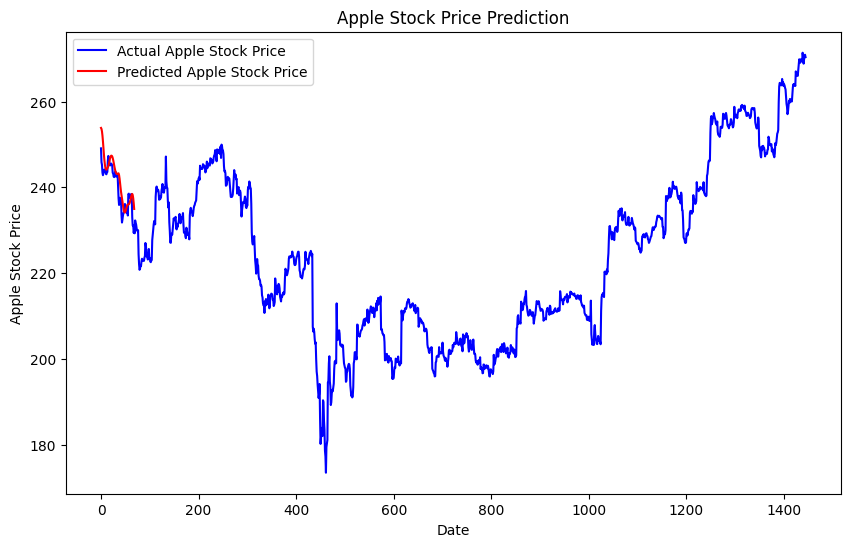

In [74]:
plt.figure(figsize=(10,6))
plt.plot(test_stock_data_processed, color='blue', label='Actual Apple Stock Price')
plt.plot(predicted_stock_price , color='red', label='Predicted Apple Stock Price')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()

In [75]:
#inputs = inputs.reshape(-1,1)
#inputs = sc.transform(inputs)


test_inputs = test_stock_data_processed.reshape(-1,1)
test_inputs = sc.transform(test_inputs)


print(test_inputs.shape)

(1445, 1)


In [76]:
test_features = []
for i in range(60, 291):
    test_features.append(test_inputs[i-60:i, 0])

test_features = np.array(test_features)

In [77]:
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))
print(test_features.shape)

(231, 60, 1)


In [78]:
predicted_stock_price = model.predict(test_features)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [79]:
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
print(predicted_stock_price.shape)

(231, 1)


In [80]:
print(test_stock_data_processed.shape)

(1445, 1)


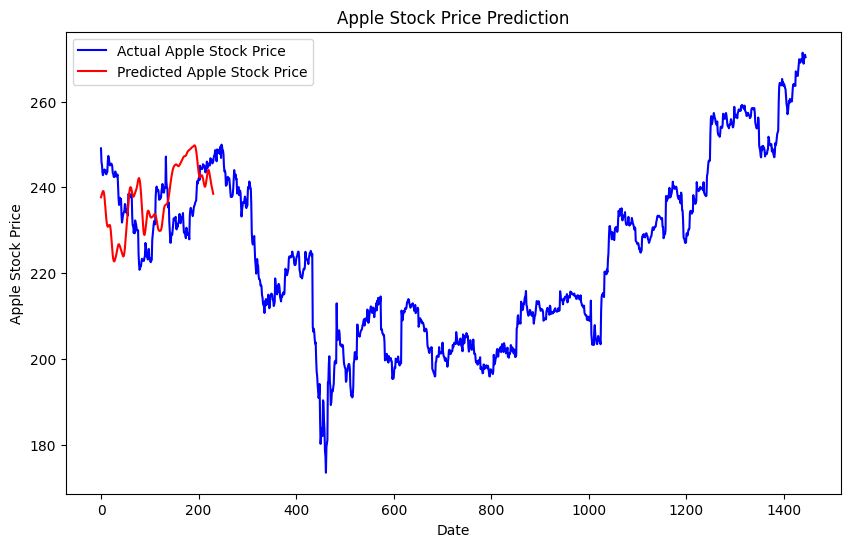

In [81]:
plt.figure(figsize=(10,6))
plt.plot(test_stock_data_processed, color='blue', label='Actual Apple Stock Price')
plt.plot(predicted_stock_price , color='red', label='Predicted Apple Stock Price')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()

## Download the model and the weights

In [ ]:
from google.colab import files

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)

In [ ]:
files.download("model.json")

In [ ]:
model.save('weights.h5')
files.download('weights.h5')